# **Hierarcial Risk Parity (HRP) for machine learning asset allocation:**

## Introduction:



Markowitz critical line algorithm has 3 critical issues : 


*   Instability
*   Concentration 
*   Under performance

These problems are address these concerns by applying modern mathematics (graph theory and machine learning) to build a diversified portfolio based on the information contained in the covariance matrix.

A practical application of HRP is to determine allocations across multiple machine learning (ML) algorithm.

Portfolio constructionn is perhaps the most reccurent financial problemes. on a daily basis, investment managers must build portfolios that incorporate their vies and forecast on risk and returns. As Markowitz highligthed with his work it is rarely optimal to allocate assets to the investment with highest expected returns as we should take the correlations between assets into account.

Given that returns can rarely be forecasted with enough certainty, people have decided to focus on the covariance matrix. This has led to risk-based asset allocation methods amoing which risk parity is prominent.
Although getting rid of forecast on returns improves the instability issue, it doesn't prevent it. Why? The inversion of the covariance matrix in quadratic programming methods is prone to large errors. This is known as the Markowitz's curse: the more correlated the investments, the greater the need for diversification and yet the more likely we will recceive unstable solutions.
Note that benefits of diversifications is most of the time off-set by estimations errors.


### From geometric to  hierarical relationships:

One reason for the instability of quadratic optimizers is that the vector space is modelled as complete (fully connected) graph, where every node is a potential candidate to substitute another.

![realtionships implied by covariance matrix of graph](https://upload.wikimedia.org/wikipedia/commons/1/14/E8Petrie.svg)
.


Actually, correlation matrices lack the notion of hierarchy whcih as for consequence to allow weights to vary freely sometimes in unintended ways (root of CLA instability).


To counter this instability, we would like to come up with a strucutre that has
* only N-1 edges to connect N nodes
* weights are distributed top-down (ex : from asset class to inidvidual security).
These are known tree-graph.

![Tree graph strucutre | 512x397,20%](https://i2.wp.com/angularscript.com/wp-content/uploads/2016/06/Angular-Bubble-Tree-Chart-Module.png?w=2120&ssl=1)
.

Don't pay attention to the things written on the picture. I seelcted the picture for its structure rather it highlights.

Note that the HRP method doesn't require the covariance matrix to be definite and positive neither inversible.

HRP algorithm is divided in 3 steps:


1.   tree clustring
2.   quasi diagonalization
3.   recursive bisection




## Libraries

In [27]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

!pip install yfinance
import yfinance as yf


## Import dataset

In [28]:
rf = 0.09 #risk-free rate at time of writing (3-month treasury bill rate)
Tickers = ['NOW', 'MSCI', 'GE', 'RMD', 'BIO', 'APD', 'MPC', 'BKNG'] #my portfolio tickers (arbitrary in SP500 list)
historical_data = yf.download(tickers= Tickers, period = "5y",group_by='ticker')

[*********************100%***********************]  8 of 8 completed


In [29]:
# Maching companies to adjusted return only
adj_close = pd.DataFrame()
for name in Tickers:
    adj_close[name] = historical_data[name]['Adj Close'] 

In [30]:
daily_returns = adj_close.pct_change() #daily returns

In [31]:
monthly_returns = daily_returns.resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.columns.names = ['Ticker']
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2016-03-31 to 2021-01-31
Freq: M
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NOW     59 non-null     float64
 1   MSCI    59 non-null     float64
 2   GE      59 non-null     float64
 3   RMD     59 non-null     float64
 4   BIO     59 non-null     float64
 5   APD     59 non-null     float64
 6   MPC     59 non-null     float64
 7   BKNG    59 non-null     float64
dtypes: float64(8)
memory usage: 4.1 KB


## Tree Clustering 

Consider the returns of N assets over T periods.


1.   Compute correlation matrix
2.   Define a distance (ex: $d[X_i, X_j] = \sqrt{\frac{1}{2}(1-\rho_{i,j})}$ and compute the corresponding distance matrix. Distances are non negatives and the matrice is symetric.
3. Compute the Euclidean distance between any two column-vectors (it gives another matrix).
4. We cluster together the pair of columns $(i^*, j^*)$ such that $(i^*, j^*) = argmin(i, j)_{i≠j}$
5. Define the distance between the newly formed cluster and the unclestered items (this process=linkage criterion)
6. Euclidean formed matrice is updated by appending $d_{i, u[1]}$ and dropping the clustered columns and rows  j include in u[1].
7. Applied steps 4, 5 and 6 recursively to form N-1 clusters.





In [32]:
cov = monthly_returns.cov()
corr = monthly_returns.corr()
corr.columns.names=['Ticker']

In [33]:
heat = go.Heatmap(z=corr,
                  x=monthly_returns.columns,
                  y=monthly_returns.columns,
                  xgap=1, ygap=1,
                  colorscale=px.colors.diverging.BrBG,
                  colorbar_thickness=20,
                  colorbar_ticklen=3,
                  hoverinfo='text'
                   )


title = 'Correlation Matrix'               

layout = go.Layout(title_text=title, title_x=0.5, 
                   width=600, height=600,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed')
   
fig=go.Figure(data=[heat], layout=layout)        
fig.show() 

In [34]:
def get_distance_matrix(corr):
    """Compute distance matrix from correlation; 
        0 <= d[i,j] <= 1""" 
    return np.sqrt((1 - corr) / 2)

In [35]:
dist_matrix = get_distance_matrix(corr)
linkage_matrix = linkage(squareform(dist_matrix), 'single')

In [36]:
print(linkage_matrix)

[[ 4.          5.          0.5876149   2.        ]
 [ 2.          8.          0.62277062  3.        ]
 [ 0.          9.          0.64614617  4.        ]
 [ 6.         10.          0.6696675   5.        ]
 [ 1.         11.          0.67690403  6.        ]
 [ 3.         12.          0.67962182  7.        ]
 [ 7.         13.          0.69786157  8.        ]]


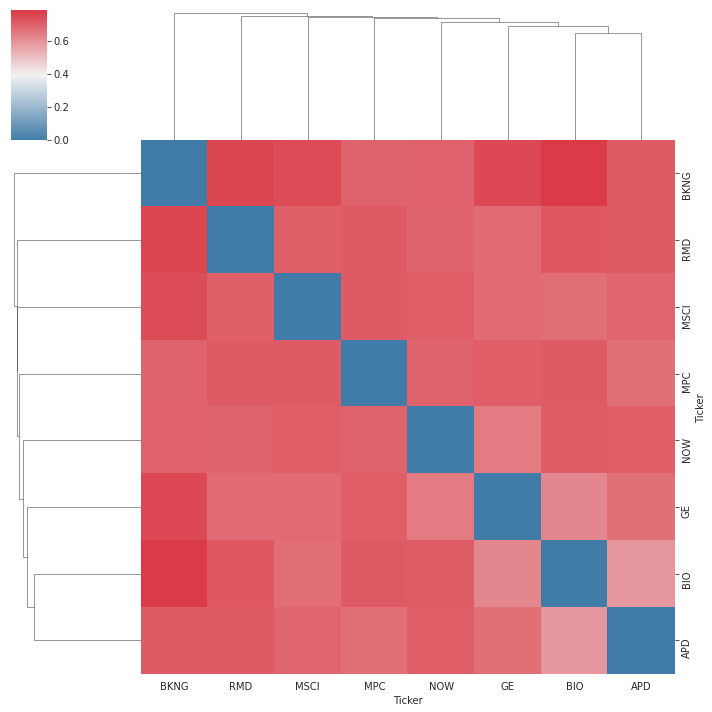

In [37]:
cmap = sns.diverging_palette(240, 10, n=4, as_cmap=True)
clustergrid = sns.clustermap(dist_matrix, 
                             method='single', 
                             row_linkage=linkage_matrix, 
                             col_linkage=linkage_matrix, 
                             cmap=cmap);

## Quasi-Diagonalization

The purpose of this step is to have the largest values lie along the diagonal(without requiring a change of basis).
This way similar investment are grouped together while dissimilar investments are far apart.

The linkage matrix consist in a (N-1)x4 matrix with structure $T = {(y_{m,1}, y_{m,2}, y_{m,3}, y_{m,4})}$ (ie: 4-tuple per cluster).

Since we know the linkage matrix merges two branches into one, it only consists in replacing $(y_{m,1}, y_{m,2})$ with their constituents recursively., until no clusters remain.
The output is a sorted list of (unclestered) items.

In [38]:

def quasi_diagonalize(link):
    """sort clustered assets by distance"""
    link = link.astype(int)
    sort_idx = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # idx of original items
    while sort_idx.max() >= num_items:
        sort_idx.index = list(range(0, sort_idx.shape[0] * 2, 2))  # make space
        df0 = sort_idx[sort_idx >= num_items]  # find clusters
        i = df0.index
        j = df0.values - num_items
        sort_idx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sort_idx = sort_idx.append(df0)  # item 2
        sort_idx = sort_idx.sort_index()  # re-sort
        sort_idx.index = list(range(sort_idx.shape[0]))  # re-index
    return sort_idx.tolist()

In [39]:
sorted_index = quasi_diagonalize(linkage_matrix)


In [40]:
print(sorted_index)

[7, 3, 1, 6, 0, 2, 4, 5]


In [41]:
sorted_tickers = corr.index[sorted_index].tolist()

In [42]:
print('New order: {}'.format(sorted_tickers))
print('Initial order: {}'.format(Tickers))

New order: ['BKNG', 'RMD', 'MSCI', 'MPC', 'NOW', 'GE', 'BIO', 'APD']
Initial order: ['NOW', 'MSCI', 'GE', 'RMD', 'BIO', 'APD', 'MPC', 'BKNG']


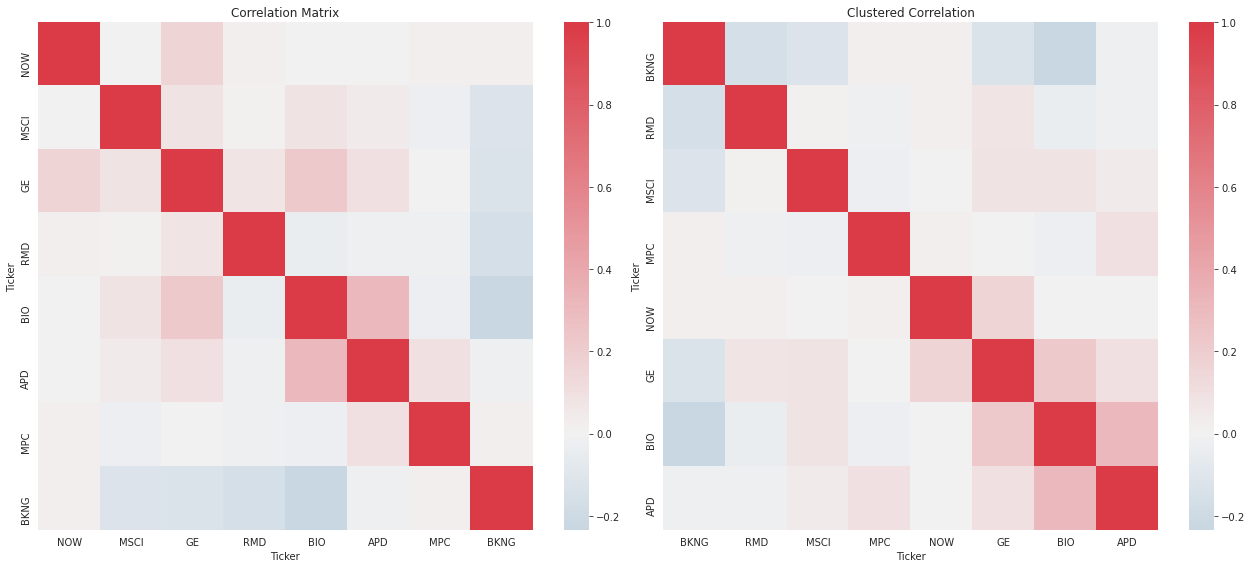

In [43]:

fig, axes = plt.subplots(ncols=2, figsize=(18, 8))
cmap = sns.diverging_palette(240, 10, n=4, as_cmap=True)

sns.heatmap(corr, center = 0, cmap = cmap, ax=axes[0])
axes[0].set_title('Correlation Matrix')
fig.tight_layout()

clustered_assets = corr.loc[sorted_tickers, sorted_tickers]  # reorder
sns.heatmap(clustered_assets, center = 0, cmap = cmap, ax=axes[1])
axes[1].set_title('Clustered Correlation')
fig.tight_layout();

## Recursive Diagonalization

Knowing that the inverse-variance allocation is optimal for a diagonal covariance matrix, we can do to things:



1.  Define the variance of a continguous subset as the variance of an inverse-variance allocation (bottom-up) 
2.   Split allocation between adjacent subset in inverse proportion to their aggregated variances

This way we mke sure that we are splitting the weights received from higher hierarical levels and that the sums of all weights is equal to 1.





In [71]:
def get_inverse_variance_portfolio(cov, **kargs):
    """Compute the inverse-variance portfolio""" 
    ivp = 1 / np.diag(cov)
    return ivp / ivp.sum()

In [76]:
def get_cluster_var(cov, cluster_items):
    """Compute variance per cluster"""
    cov_ = cov.loc[cluster_items, cluster_items]  # matrix slice
    w_ = get_inverse_variance_portfolio(cov_)
    return (w_ @ cov_ @ w_).item()

In [77]:
def get_hrp_allocation(cov, sortedIndex):
    """Compute top-down HRP weights"""
    tickers = corr.index[sorted_index].tolist()
    weights = pd.Series(1, index=tickers)
    clusters = [tickers]  # initialize one cluster with all assets

    while len(clusters) > 0:
        # run bisectional search:
        clusters = [c[start:stop] for c in clusters
                    for start, stop in ((0, int(len(c) / 2)),
                                        (int(len(c) / 2), len(c)))
                    if len(c) > 1]

        for i in range(0, len(clusters), 2):  # parse in pairs
            cluster0 = clusters[i]
            cluster1 = clusters[i + 1]

            cluster0_var = get_cluster_var(cov, cluster0)
            cluster1_var = get_cluster_var(cov, cluster1)
    
            weight_scaler = 1 - cluster0_var / (cluster0_var + cluster1_var)
            weights[cluster0] *= weight_scaler
            weights[cluster1] *= 1 - weight_scaler
    return weights

In [79]:

hrp_allocation = get_hrp_allocation(cov, sorted_index)*100


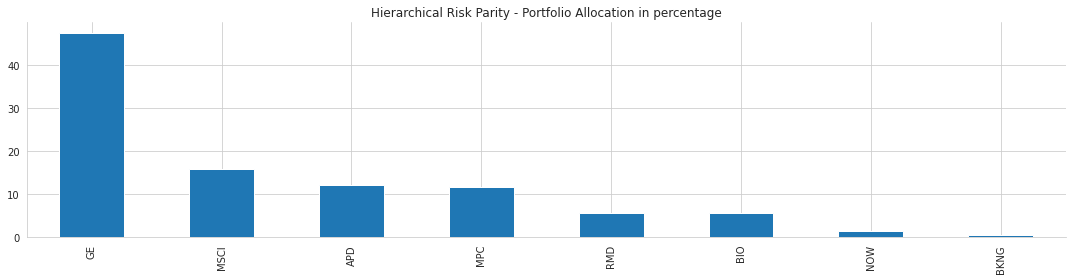

In [82]:

title = 'Hierarchical Risk Parity - Portfolio Allocation in percentage'
hrp_allocation.sort_values(ascending=False).iloc[:].plot.bar(figsize=(15, 4),
                                                               title=title)
sns.despine()
plt.tight_layout()

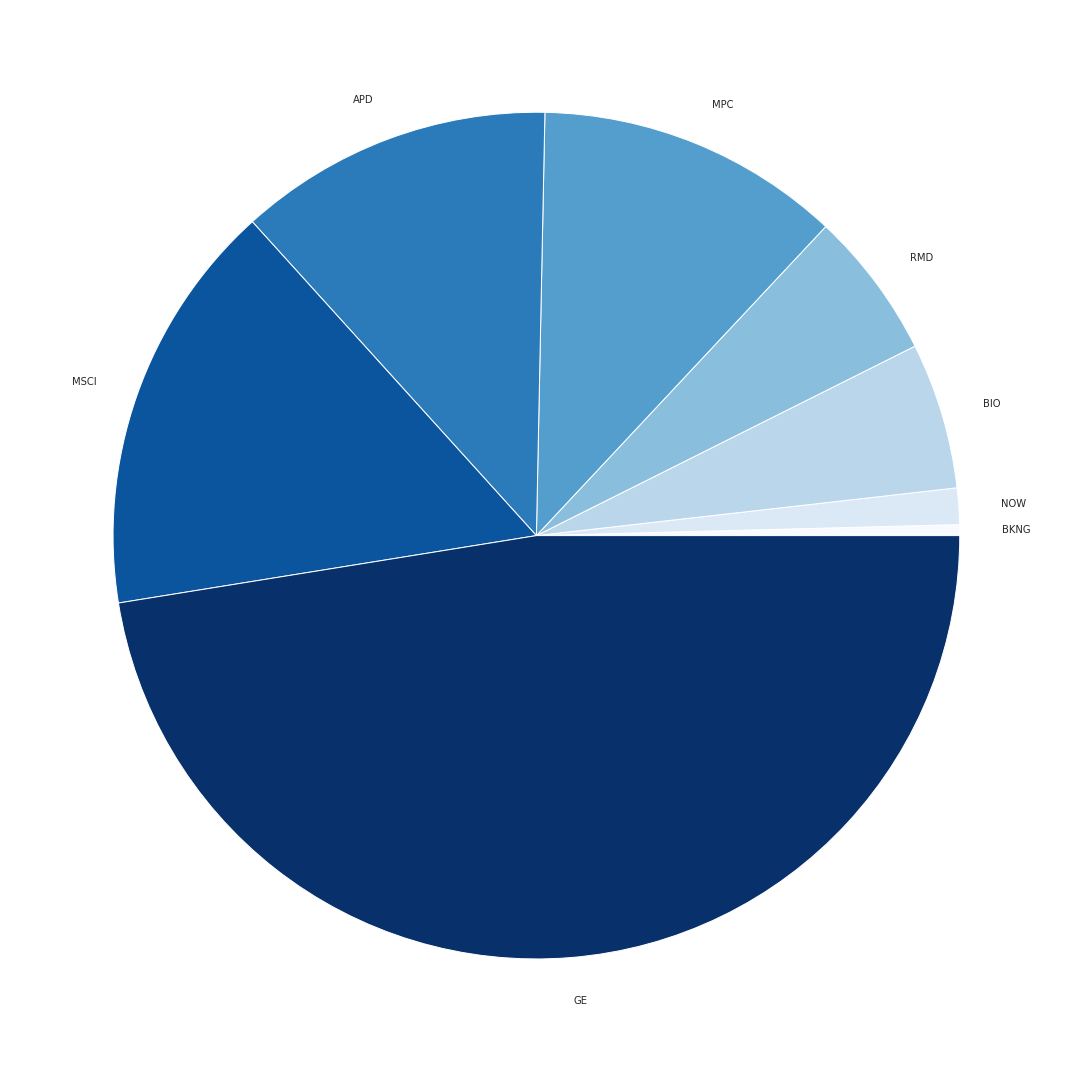

In [86]:
ax = hrp_allocation.sort_values().plot.pie(figsize=(15, 15), 
                                      cmap='Blues')
ax.set_ylabel('')
plt.tight_layout();
